In [3]:
%matplotlib inline  
####################################
from PIL import Image, ImageFilter
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tight_subplot import tight_subplot_2x5
from nonmax import non_max_suppression

## 1. Image Pyramids

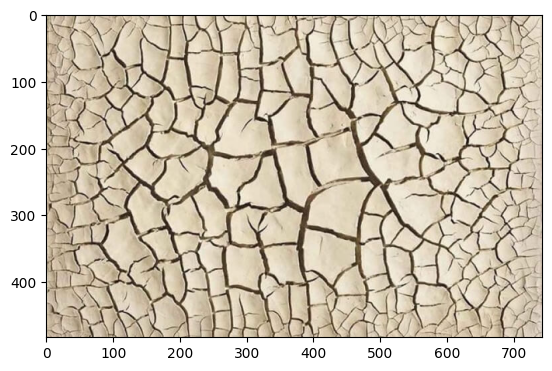

In [4]:
img = Image.open("texture.jpeg")
imshow(img)

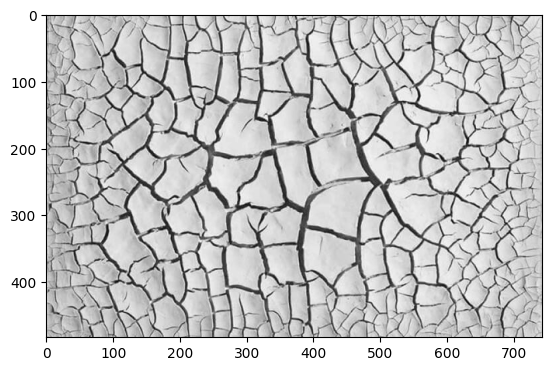

In [138]:
img_gray = img.convert("L")
img_gray.save("texture_gray.jpeg")
imshow(img_gray, cmap="gray")

In [142]:
def gaussian_pyramid(img_path, levels):
    pyramid = []
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gaussian_kernel = cv2.getGaussianKernel(5, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel, gaussian_kernel.transpose())
    pyramid.append(img)
    for i in range(levels - 1):
        blurred = cv2.filter2D(img, -1, gaussian_kernel_2d)
        img = cv2.pyrDown(blurred)
        pyramid.append(img)
        
    return pyramid

In [143]:
def laplacian_pyramid(gaussian_pyramid):
    pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        gaussian_current = gaussian_pyramid[i]
        gaussian_next = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=gaussian_current.shape[:2][::-1])
        pyramid.append(gaussian_current - gaussian_next)
    return pyramid

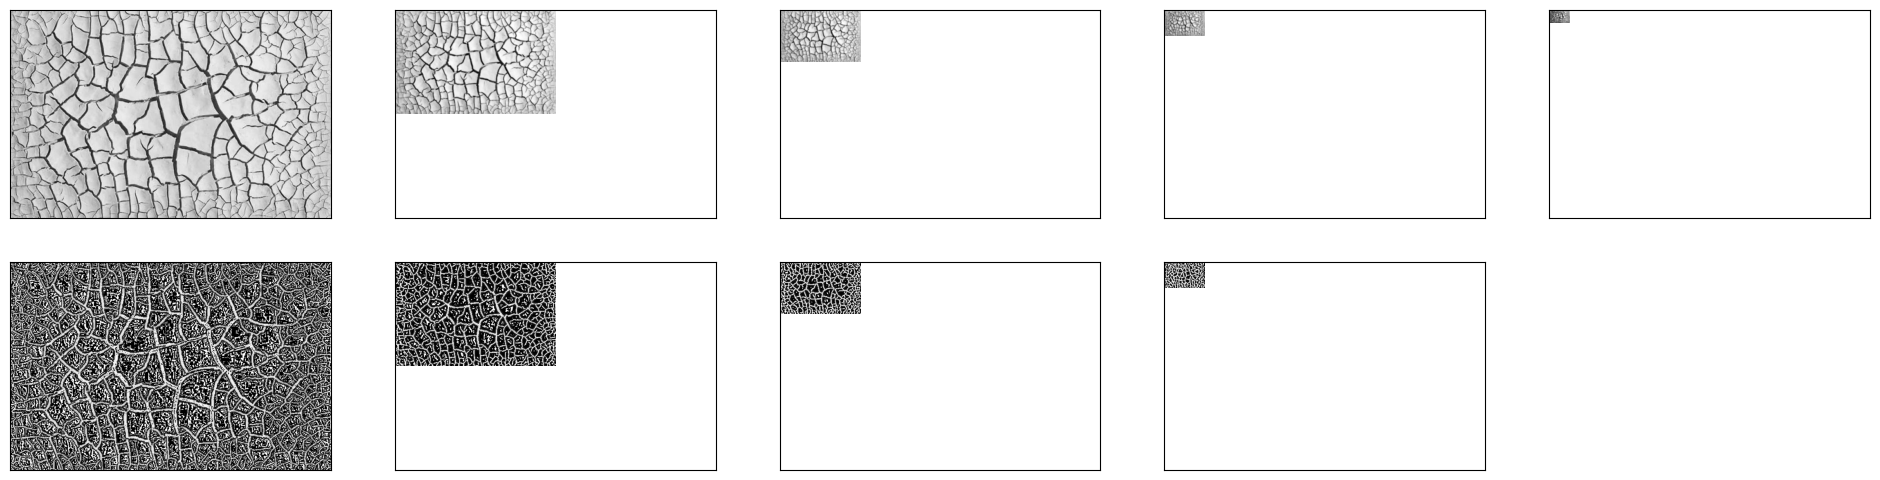

In [144]:
gaussian_pyramid_imgs = gaussian_pyramid("./texture_gray.jpeg", 5)
laplacian_pyramid_imgs = laplacian_pyramid(gaussian_pyramid_imgs)
tight_subplot_2x5(gaussian_pyramid_imgs, laplacian_pyramid_imgs)

In [145]:
def plot_fft_amplitudes(pyramid):
    plt.figure(figsize=(20, 10))
    for i in range(len(pyramid)):
        plt.subplot(2, 5, i+1)
        f = np.fft.fft2(pyramid[i].astype(np.float32))
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20*np.log(np.abs(fshift) + 1)
        magnitude_spectrum = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        plt.imshow(magnitude_spectrum, vmin=0, vmax=255, cmap="gray")
    plt.show()

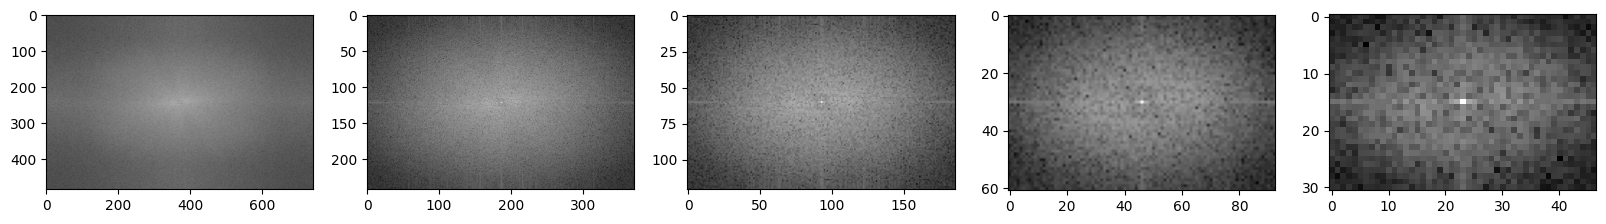

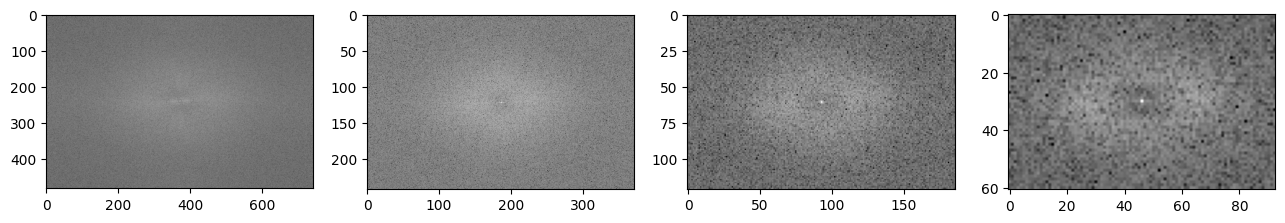

In [146]:
plot_fft_amplitudes(gaussian_pyramid_imgs)
plot_fft_amplitudes(laplacian_pyramid_imgs)

## 2. Edge Detection

### 2.1 Gradient-Based Edge Detector

In [166]:
def gradientMagnitude(img_mat: np.ndarray, gaussian_kernel_2d: np.ndarray, angle_degrees):
    img_mat = img_mat.astype(np.float32)
    angle_radians = np.deg2rad(angle_degrees)
    
    sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_filter_y = -sobel_filter_x.T
    
    sobel_filter_x = sobel_filter_x * np.cos(angle_radians) - sobel_filter_y * np.sin(angle_radians)
    sobel_filter_y = sobel_filter_x * np.sin(angle_radians) + sobel_filter_y * np.cos(angle_radians)
    
    
    gradient_x = np.zeros_like(img_mat)
    gradient_y = np.zeros_like(img_mat)
    
    for channel in range(3):
        blurred = cv2.filter2D(img_mat[:,:,channel], -1, gaussian_kernel_2d)
        # blurred = np.uint8((blurred / np.max(blurred)) * 255)
        
        # channel_gradient_x, channel_gradient_y = cv2.spatialGradient(blurred, 3)
        gradient_x[:,:,channel] = cv2.filter2D(blurred, -1, sobel_filter_x)
        gradient_y[:,:,channel] = cv2.filter2D(blurred, -1, sobel_filter_y)
        
    
    largest_gradient_channel = np.argmax(np.sqrt(gradient_x**2 + gradient_y**2), axis=2)
    gradient_theta = np.arctan2(np.take_along_axis(gradient_y, np.expand_dims(largest_gradient_channel, axis=2), axis=2).squeeze(), np.take_along_axis(gradient_x, np.expand_dims(largest_gradient_channel, axis=2), axis=2).squeeze())
    gradient_magnitude = np.sqrt(np.sum(gradient_x**2 + gradient_y**2, axis=2))
    
    return gradient_magnitude, gradient_theta

In [4]:
img_plane = cv2.imread("plane.jpg")
# gradientMagnitude(img_plane, 1)

In [149]:
def edgeGradient(img_mat):
    sigma = 1
    gaussian_kernel = cv2.getGaussianKernel(6*sigma+1, sigma)
    gaussian_kernel_2d = np.outer(gaussian_kernel, gaussian_kernel.transpose())
    grad_mag, grad_theta = gradientMagnitude(img_mat, gaussian_kernel_2d, 0)
    
    return non_max_suppression(grad_mag, grad_theta)

Text(0.5, 1.0, 'Theta')

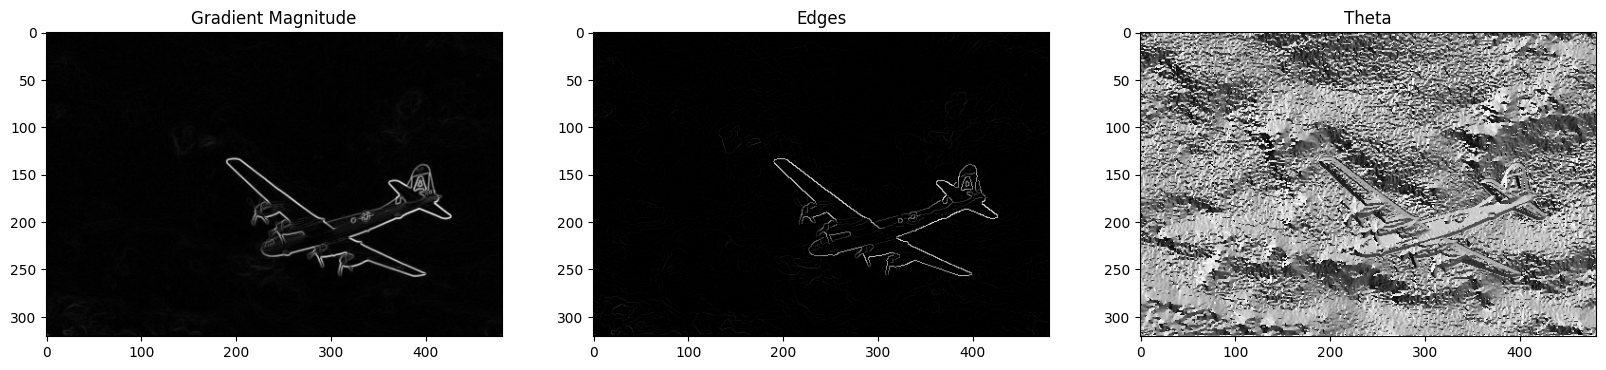

In [175]:
sigma = 0
gaussian_kernel = cv2.getGaussianKernel(6*sigma+1, sigma)
gaussian_kernel_2d = np.outer(gaussian_kernel, gaussian_kernel.transpose())
grad_mag, grad_theta = gradientMagnitude(img_plane, gaussian_kernel_2d, 0)
edges = edgeGradient(img_plane)

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(grad_mag, cmap="gray")
plt.title("Gradient Magnitude")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap="gray")
plt.title("Edges")

plt.subplot(1, 3, 3)
plt.imshow(grad_theta, cmap="gray")
plt.title("Theta")

### 2.2 Oriented Filters

In [249]:
def orientedFilterMagnitude(img_mat):
    img_mat = img_mat.astype(np.float32)
    orientations = np.linspace(0, 360, 12, endpoint=False)
    sigma_x, sigma_y = 1, 1
    
    max_filter_response = np.zeros_like(img_mat[:,:,0])
    max_filter_orientation = np.zeros_like(img_mat[:,:,0])
    
    angle_imgs = []
    
    for angle in orientations:
        angle_oriented_gaussian_kernel = oriented_gaussian_kernel(6*max(sigma_x, sigma_y)+1, sigma_x, sigma_y, angle)
        
        oriented_grad_mag, oriented_grad_angle = gradientMagnitude(img_mat, angle_oriented_gaussian_kernel, angle)
        
        angle_imgs.append(oriented_grad_mag)
        
        max_filter_response = np.maximum(max_filter_response, oriented_grad_mag)
        max_filter_orientation = np.where(oriented_grad_mag == max_filter_response, oriented_grad_angle, max_filter_orientation)
        
    
    return np.max(np.array(angle_imgs), axis=0), max_filter_orientation
        
        
def oriented_gaussian_kernel(size, sigma_x, sigma_y, angle):
    x, y = np.mgrid[-size//2:size//2+1, -size//2:size//2+1]
    
    x_rotated = x * np.cos(np.deg2rad(angle)) + y * np.sin(np.deg2rad(angle))
    y_rotated = -x * np.sin(np.deg2rad(angle)) + y * np.cos(np.deg2rad(angle))
    
    gaussian_kernel = np.exp(-0.5 * (x_rotated**2 / sigma_x**2 + y_rotated**2 / sigma_y**2))
    return gaussian_kernel / np.sum(gaussian_kernel)


In [78]:
def edgeOrientedFilters(img_mat):
    grad_mag, grad_theta = orientedFilterMagnitude(img_mat)
    
    return non_max_suppression(grad_mag, grad_theta)

Text(0.5, 1.0, 'Oriented Angle')

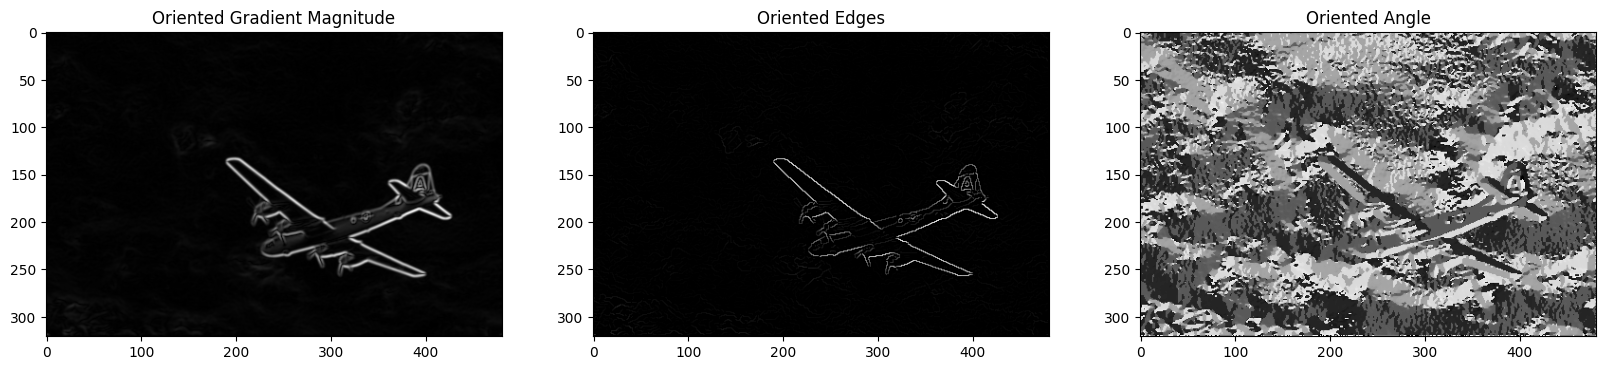

In [250]:
oriented_mag, oriented_angle = orientedFilterMagnitude(img_plane)
oriented_edges = edgeOrientedFilters(img_plane)
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(oriented_mag, cmap="gray")
plt.title("Oriented Gradient Magnitude")

plt.subplot(1, 3, 2)
plt.imshow(oriented_edges, cmap="gray")
plt.title("Oriented Edges")

plt.subplot(1, 3, 3)
plt.imshow(oriented_angle, cmap="gray")
plt.title("Oriented Angle")